In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

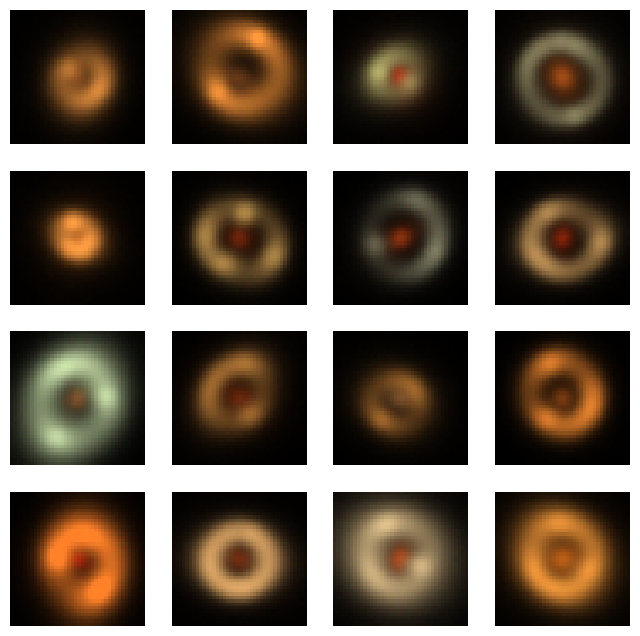

In [4]:
# Visualize source data
visualize_data(source_data)

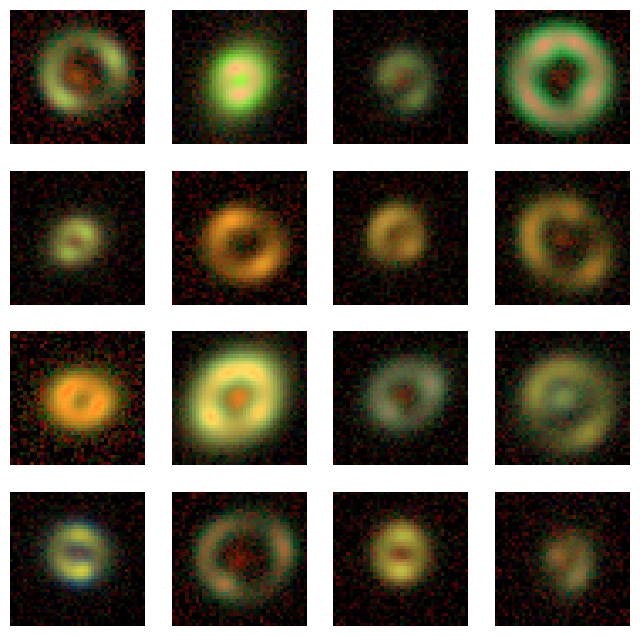

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    # if epoch < evolv_epoch:
    #     da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    # else:
    #     da_weight = final_wt_da
    return 1.4

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    if epoch < evolv_epoch:
        beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    else:
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5

n_epoch = 200
evolv_epoch = 50

beta_init = 1.0
beta_final = 0.7

# init_wt_da = 1.4
# final_wt_da = 1.0

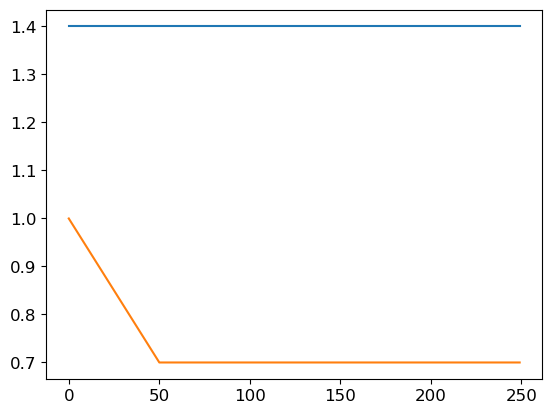

In [7]:
s = np.arange(250)
plt.plot(s, [da_weight_function(i) for i in s])
plt.plot(s, [beta_function(i) for i in s])

In [8]:
from torch.optim.lr_scheduler import MultiStepLR
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[50, 100, 150, 200], gamma=0.1)

In [9]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_v9_aug24_2240"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


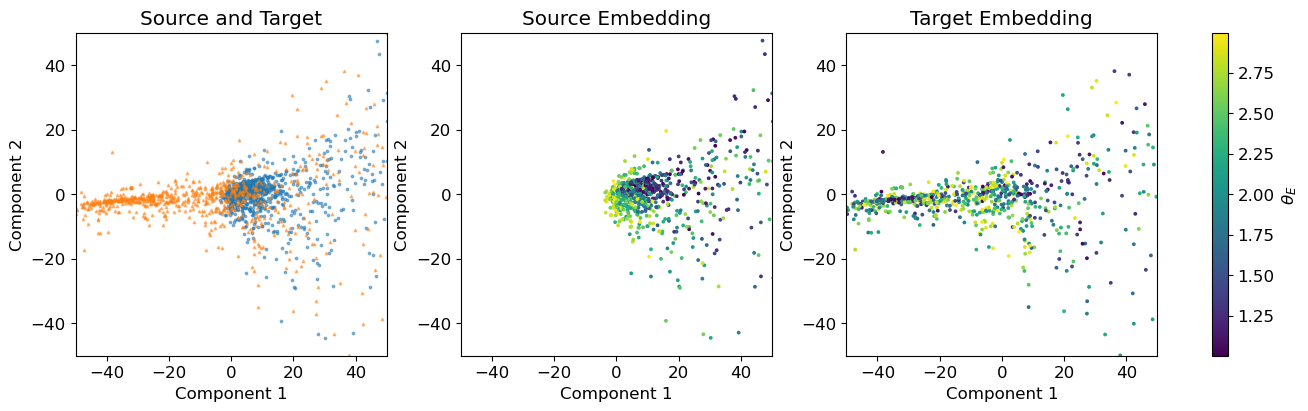


Epoch 0: 50.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4657
	Train Regression Loss: : 2.0740
	Train Mve Loss: : 0.8835
	Train R2 Score: : -5.3215
 Validation Statistics:
	Val Source Regression Loss: : 0.7792
	Val Target Regression Loss: : 0.7237
	Val Source R2 Score: : -1.3843
	Val Target R2 Score: : -1.1479
	Val Source Mve Loss: : 0.2336
	Val Target Mve Loss: : 0.2026
	Val Source Nll Loss: : 0.4683
	Val Target Nll Loss: : 0.4784
Saving Model MVE... Done.
Saving Model NLL... Done.

Epoch 1: 47.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3152
	Train Regression Loss: : 0.4474
	Train Mve Loss: : 0.0646
	Train R2 Score: : -0.3524
 Validation Statistics:
	Val Source Regression Loss: : 0.2845
	Val Target Regression Loss: : 0.2971
	Val Source R2 Score: : 0.1328
	Val Target R2 Score: : 0.1145
	Val Source Mve Loss: : -0.0218
	Val Target Mve Loss: : -0.0200
	Val Source Nll Loss: : -0.0728
	Val Target Nll Loss: : -0.0430
Saving

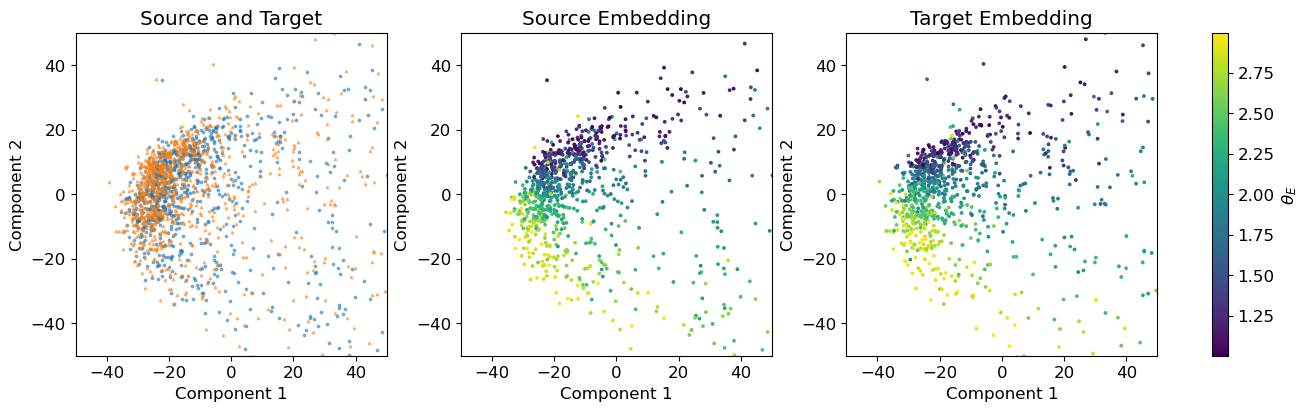


Epoch 20: 50.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0317
	Train Regression Loss: : 0.0205
	Train Mve Loss: : -0.1033
	Train R2 Score: : 0.9378
 Validation Statistics:
	Val Source Regression Loss: : 0.0203
	Val Target Regression Loss: : 0.0271
	Val Source R2 Score: : 0.9378
	Val Target R2 Score: : 0.9190
	Val Source Mve Loss: : -0.0765
	Val Target Mve Loss: : -0.0736
	Val Source Nll Loss: : 6721.5765
	Val Target Nll Loss: : 7133.6656

Epoch 21: 60.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0310
	Train Regression Loss: : 0.0198
	Train Mve Loss: : -0.1037
	Train R2 Score: : 0.9401
 Validation Statistics:
	Val Source Regression Loss: : 0.0196
	Val Target Regression Loss: : 0.0272
	Val Source R2 Score: : 0.9400
	Val Target R2 Score: : 0.9192
	Val Source Mve Loss: : -0.1059
	Val Target Mve Loss: : -0.1027
	Val Source Nll Loss: : 1861.6209
	Val Target Nll Loss: : 2070.1820

Epoch 22: 58.93s
----------------------------

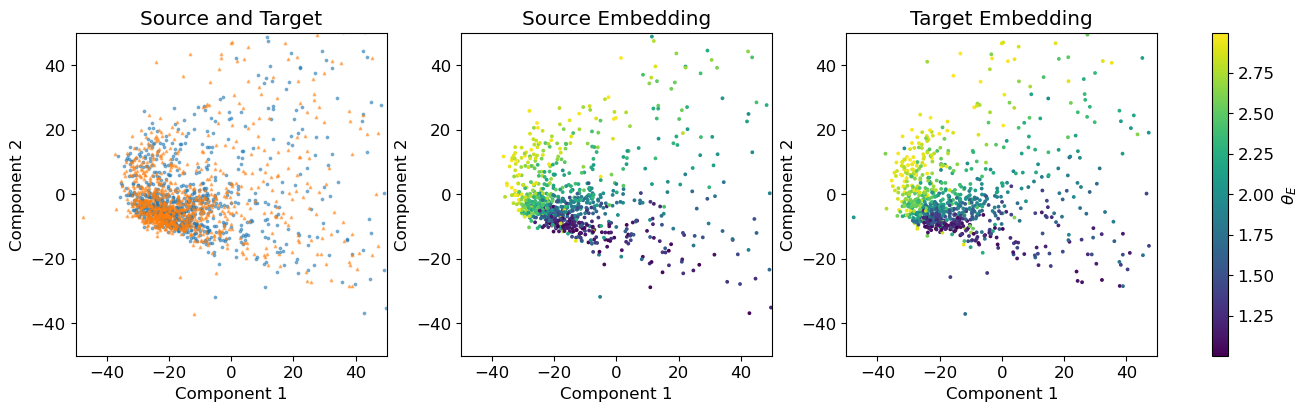


Epoch 40: 49.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0280
	Train Regression Loss: : 0.0177
	Train Mve Loss: : -0.1104
	Train R2 Score: : 0.9464
 Validation Statistics:
	Val Source Regression Loss: : 0.0175
	Val Target Regression Loss: : 0.0237
	Val Source R2 Score: : 0.9463
	Val Target R2 Score: : 0.9296
	Val Source Mve Loss: : -0.0852
	Val Target Mve Loss: : -0.0656
	Val Source Nll Loss: : 3792.3070
	Val Target Nll Loss: : 6576.9399
Saving Model... Done.

Epoch 41: 61.21s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0274
	Train Regression Loss: : 0.0175
	Train Mve Loss: : -0.1144
	Train R2 Score: : 0.9471
 Validation Statistics:
	Val Source Regression Loss: : 0.0172
	Val Target Regression Loss: : 0.0239
	Val Source R2 Score: : 0.9473
	Val Target R2 Score: : 0.9291
	Val Source Mve Loss: : -0.1328
	Val Target Mve Loss: : -0.1200
	Val Source Nll Loss: : 503.7411
	Val Target Nll Loss: : 1755.6464

Epoch 42: 53.31s
-------

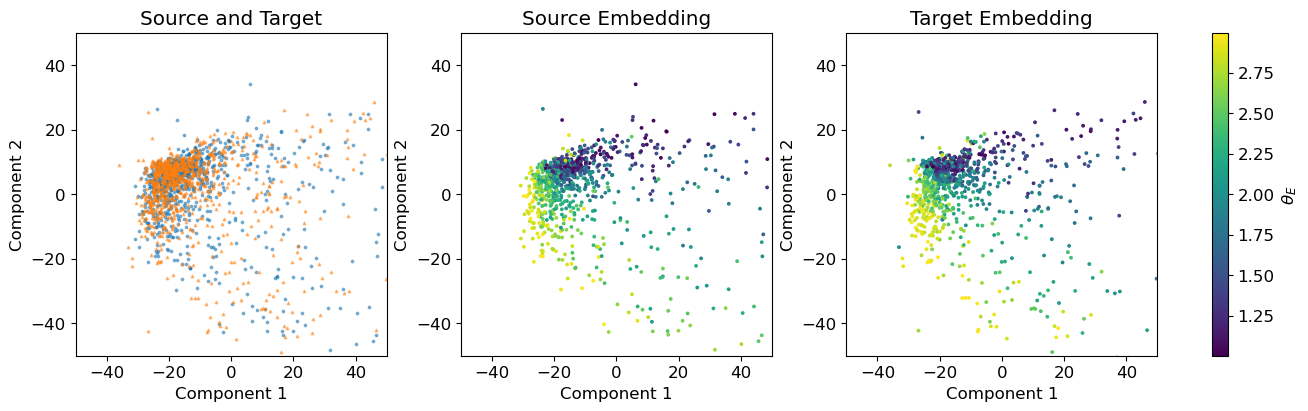


Epoch 60: 52.21s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0270
	Train Regression Loss: : 0.0165
	Train Mve Loss: : -0.2115
	Train R2 Score: : 0.9500
 Validation Statistics:
	Val Source Regression Loss: : 0.0162
	Val Target Regression Loss: : 0.0215
	Val Source R2 Score: : 0.9502
	Val Target R2 Score: : 0.9357
	Val Source Mve Loss: : -0.2086
	Val Target Mve Loss: : -0.2013
	Val Source Nll Loss: : 952.5756
	Val Target Nll Loss: : 1151.7691
Saving Model... Done.

Epoch 61: 52.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0270
	Train Regression Loss: : 0.0165
	Train Mve Loss: : -0.2050
	Train R2 Score: : 0.9502
 Validation Statistics:
	Val Source Regression Loss: : 0.0161
	Val Target Regression Loss: : 0.0223
	Val Source R2 Score: : 0.9507
	Val Target R2 Score: : 0.9336
	Val Source Mve Loss: : -0.1966
	Val Target Mve Loss: : -0.1920
	Val Source Nll Loss: : 1302.6314
	Val Target Nll Loss: : 1221.2044

Epoch 62: 53.10s
-------

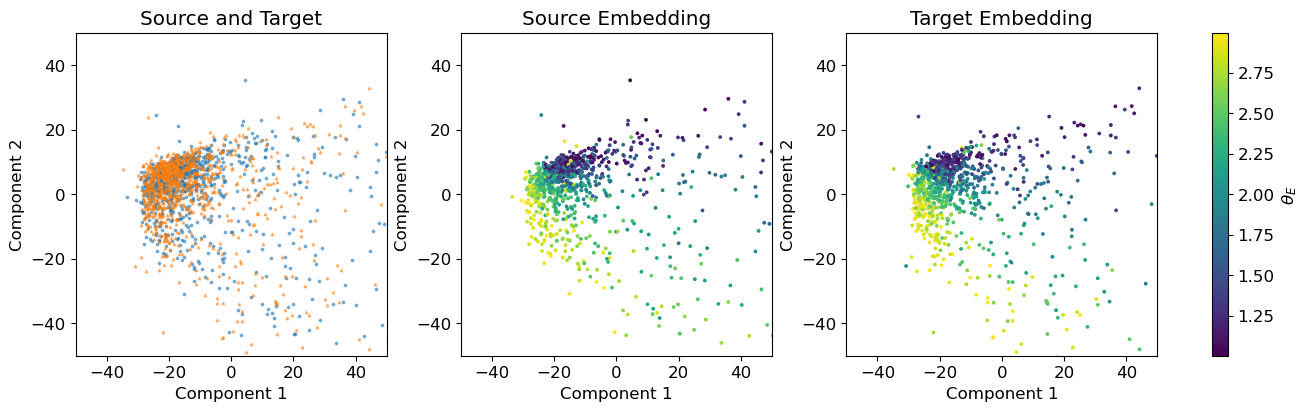


Epoch 80: 58.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0269
	Train Regression Loss: : 0.0154
	Train Mve Loss: : -0.1253
	Train R2 Score: : 0.9532
 Validation Statistics:
	Val Source Regression Loss: : 0.0156
	Val Target Regression Loss: : 0.0211
	Val Source R2 Score: : 0.9517
	Val Target R2 Score: : 0.9367
	Val Source Mve Loss: : -0.1195
	Val Target Mve Loss: : -0.0895
	Val Source Nll Loss: : 1472.3941
	Val Target Nll Loss: : 3341.0911

Epoch 81: 57.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0267
	Train Regression Loss: : 0.0154
	Train Mve Loss: : -0.1350
	Train R2 Score: : 0.9533
 Validation Statistics:
	Val Source Regression Loss: : 0.0153
	Val Target Regression Loss: : 0.0206
	Val Source R2 Score: : 0.9524
	Val Target R2 Score: : 0.9390
	Val Source Mve Loss: : -0.1173
	Val Target Mve Loss: : -0.0937
	Val Source Nll Loss: : 1760.1129
	Val Target Nll Loss: : 3119.2203
Saving Model... Done.

Epoch 82: 58.32s
------

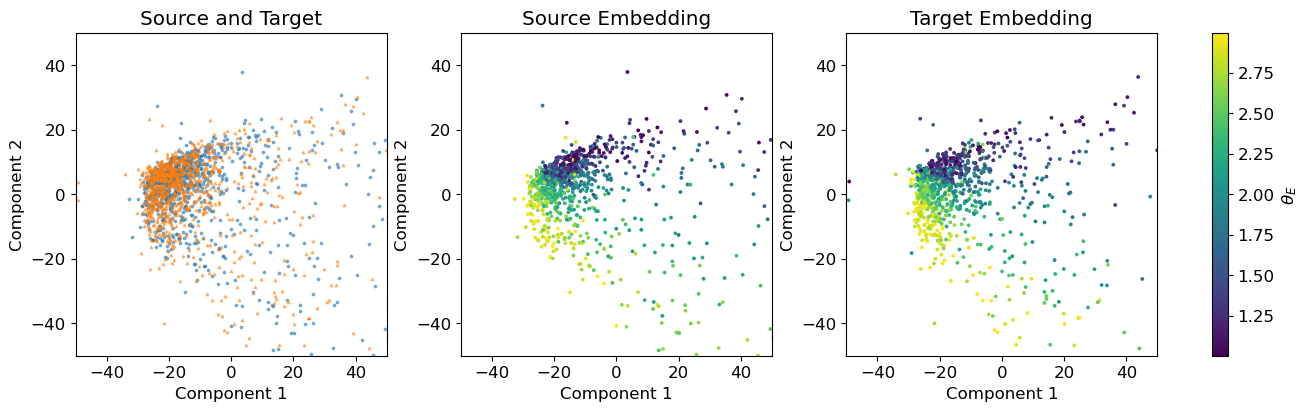


Epoch 100: 50.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0261
	Train Regression Loss: : 0.0151
	Train Mve Loss: : -0.1544
	Train R2 Score: : 0.9543
 Validation Statistics:
	Val Source Regression Loss: : 0.0148
	Val Target Regression Loss: : 0.0203
	Val Source R2 Score: : 0.9546
	Val Target R2 Score: : 0.9397
	Val Source Mve Loss: : -0.1500
	Val Target Mve Loss: : -0.1406
	Val Source Nll Loss: : 866.0319
	Val Target Nll Loss: : 1093.2861
Saving Model... Done.

Epoch 101: 52.90s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0258
	Train Regression Loss: : 0.0150
	Train Mve Loss: : -0.1523
	Train R2 Score: : 0.9545
 Validation Statistics:
	Val Source Regression Loss: : 0.0146
	Val Target Regression Loss: : 0.0205
	Val Source R2 Score: : 0.9551
	Val Target R2 Score: : 0.9391
	Val Source Mve Loss: : -0.1476
	Val Target Mve Loss: : -0.1375
	Val Source Nll Loss: : 859.7772
	Val Target Nll Loss: : 1163.3529

Epoch 102: 54.30s
-----

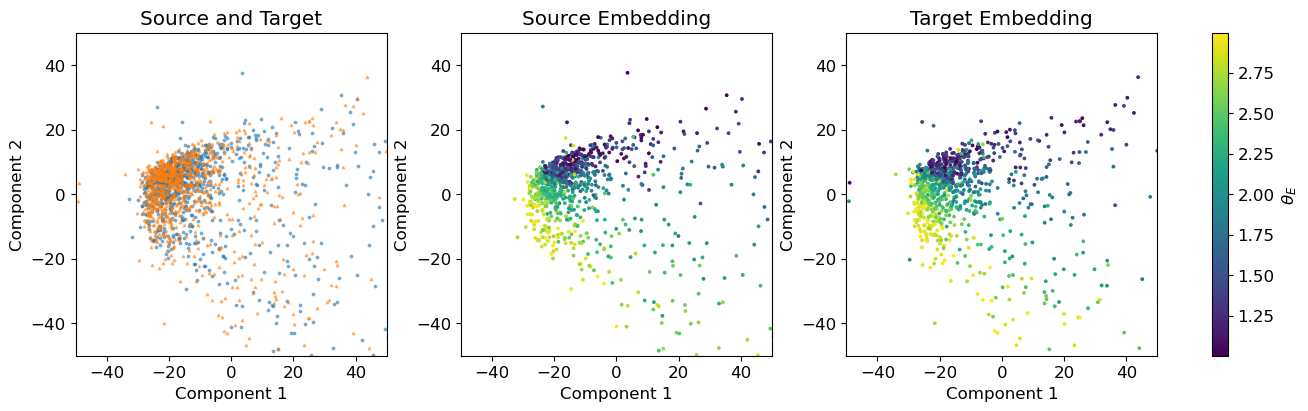


Epoch 120: 48.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0253
	Train Regression Loss: : 0.0150
	Train Mve Loss: : -0.1449
	Train R2 Score: : 0.9546
 Validation Statistics:
	Val Source Regression Loss: : 0.0148
	Val Target Regression Loss: : 0.0203
	Val Source R2 Score: : 0.9544
	Val Target R2 Score: : 0.9398
	Val Source Mve Loss: : -0.1403
	Val Target Mve Loss: : -0.1290
	Val Source Nll Loss: : 955.3754
	Val Target Nll Loss: : 1348.3269
Saving Model... Done.

Epoch 121: 54.38s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0254
	Train Regression Loss: : 0.0150
	Train Mve Loss: : -0.1463
	Train R2 Score: : 0.9545
 Validation Statistics:
	Val Source Regression Loss: : 0.0152
	Val Target Regression Loss: : 0.0203
	Val Source R2 Score: : 0.9534
	Val Target R2 Score: : 0.9394
	Val Source Mve Loss: : -0.1393
	Val Target Mve Loss: : -0.1294
	Val Source Nll Loss: : 1015.4236
	Val Target Nll Loss: : 1363.1340

Epoch 122: 48.51s
----

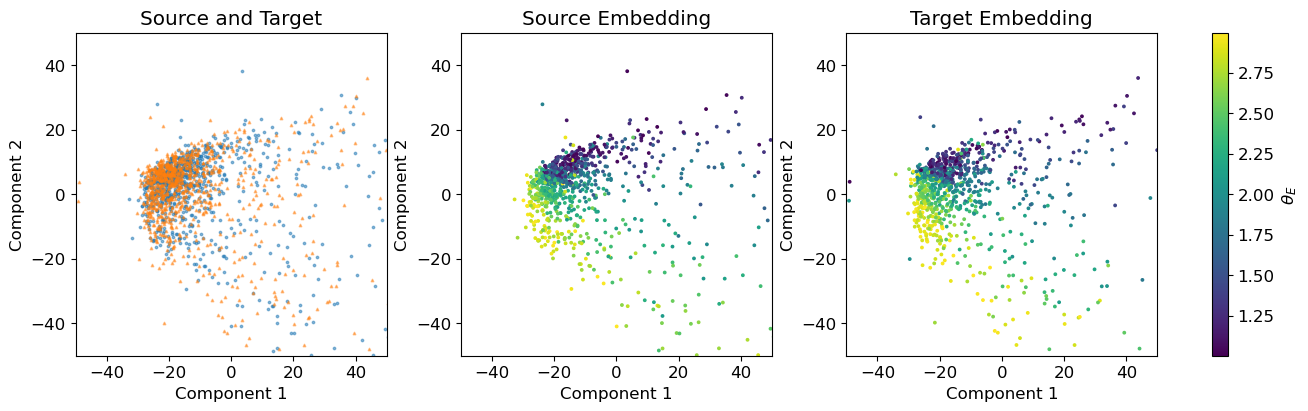


Epoch 140: 48.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0254
	Train Regression Loss: : 0.0150
	Train Mve Loss: : -0.1398
	Train R2 Score: : 0.9546
 Validation Statistics:
	Val Source Regression Loss: : 0.0151
	Val Target Regression Loss: : 0.0208
	Val Source R2 Score: : 0.9532
	Val Target R2 Score: : 0.9305
	Val Source Mve Loss: : -0.1352
	Val Target Mve Loss: : -0.1187
	Val Source Nll Loss: : 892.6299
	Val Target Nll Loss: : 1662.6253

Epoch 141: 49.93s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0258
	Train Regression Loss: : 0.0149
	Train Mve Loss: : -0.1398
	Train R2 Score: : 0.9547
 Validation Statistics:
	Val Source Regression Loss: : 0.0148
	Val Target Regression Loss: : 0.0209
	Val Source R2 Score: : 0.9542
	Val Target R2 Score: : 0.9366
	Val Source Mve Loss: : -0.1396
	Val Target Mve Loss: : -0.1145
	Val Source Nll Loss: : 636.2737
	Val Target Nll Loss: : 2045.9104

Epoch 142: 56.44s
---------------------------

KeyboardInterrupt: 

In [10]:
print("Beginning Training...")
stats['lr'] = []
for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        scheduler.step()

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [11]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [12]:
# Loads a model for plotting/viz

viz_mod_name = save_mod_name#"models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

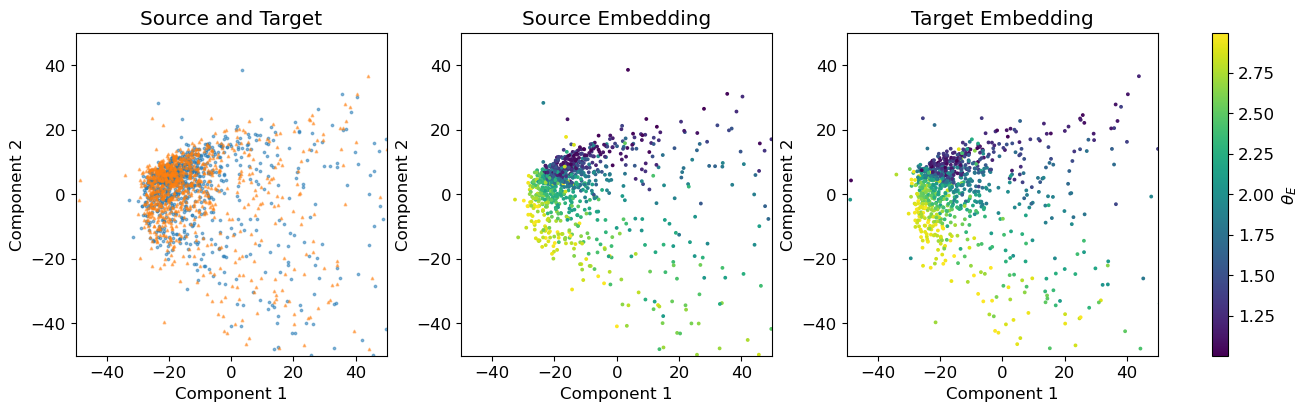

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [13]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

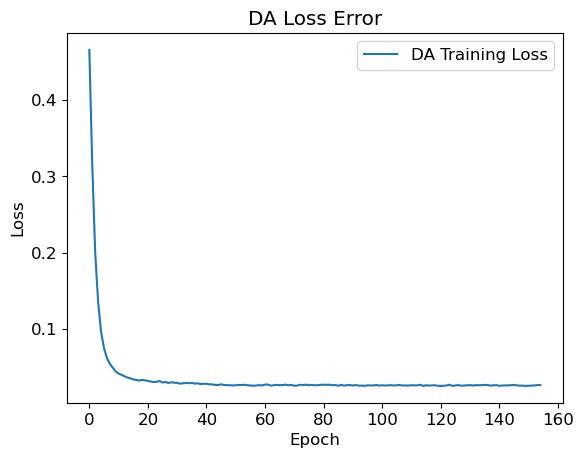

In [14]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

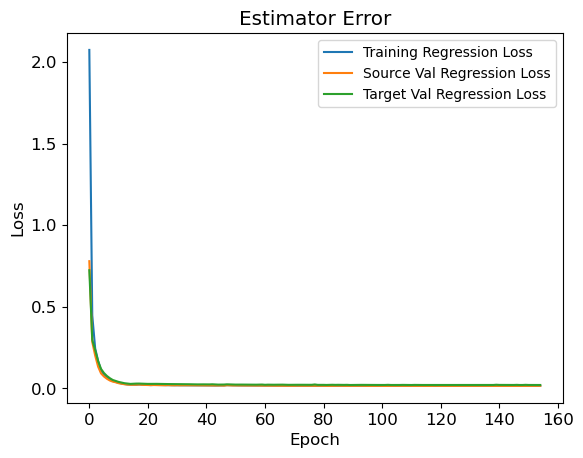

In [15]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

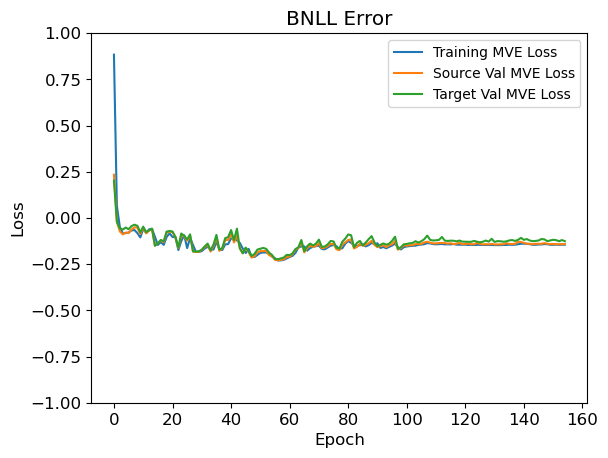

In [16]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(-2.0, 1.0)

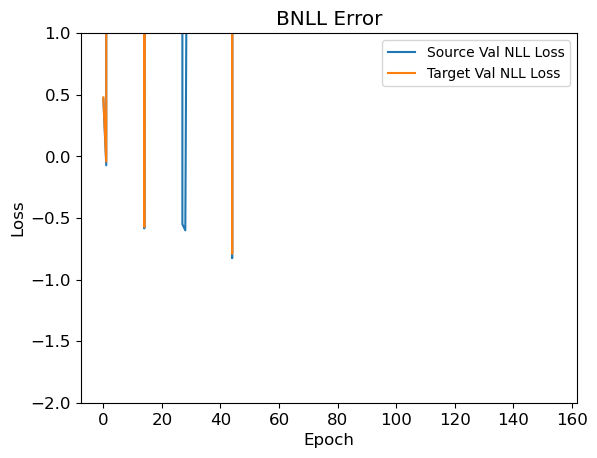

In [17]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['val_source_nll_loss'], label = "Source Val NLL Loss")
plt.plot(eps, stats['val_target_nll_loss'], label = "Target Val NLL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-2, 1)

(0.5, 1.0)

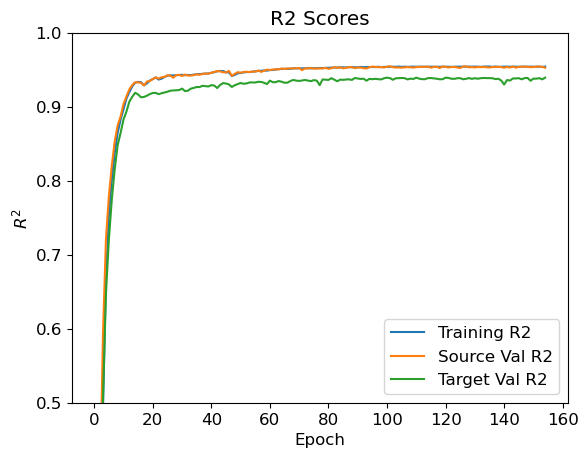

In [18]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [29]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.0))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9687


Text(0.5, 1.0, 'MMD | Source | R2: 0.969')

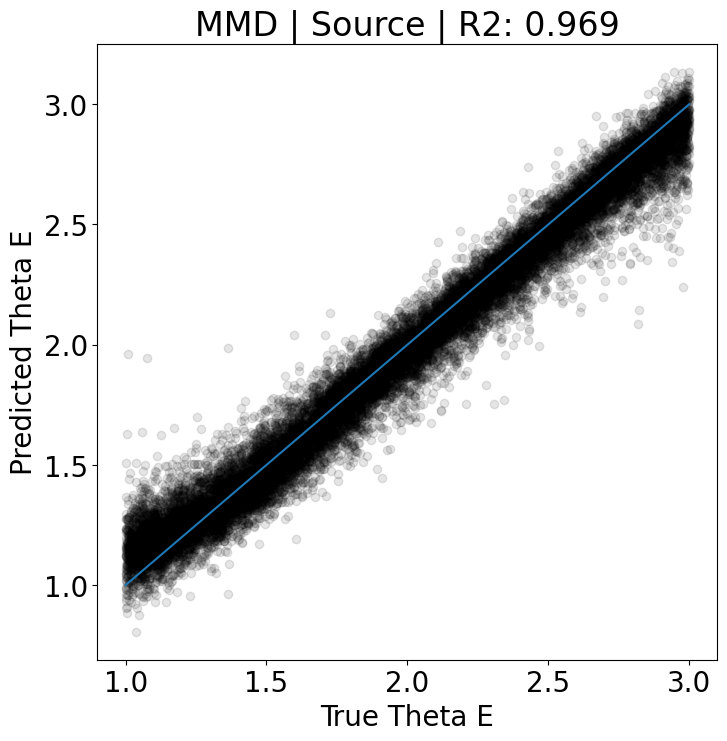

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | NLL: 131.683')

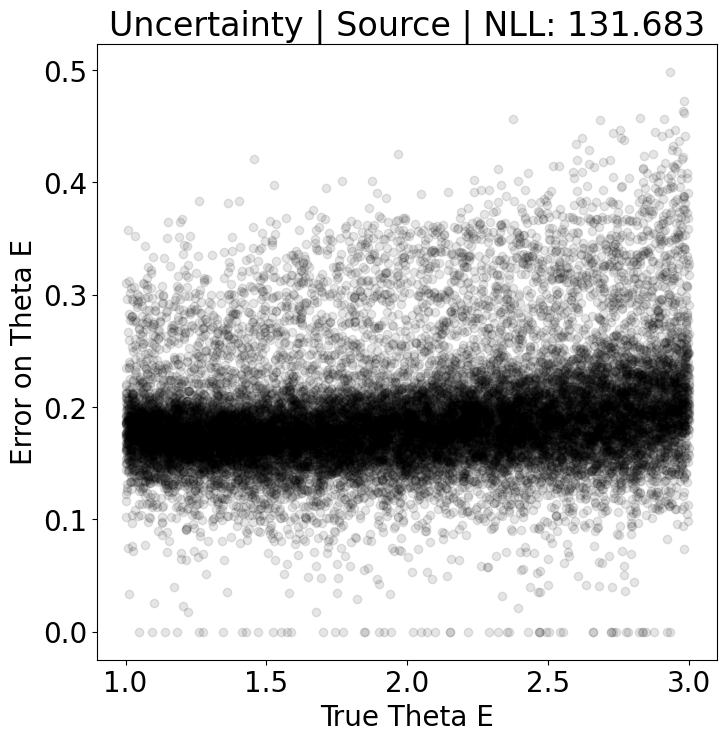

In [31]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | NLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [32]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9579


Text(0.5, 1.0, 'MMD | Target | R2: 0.958')

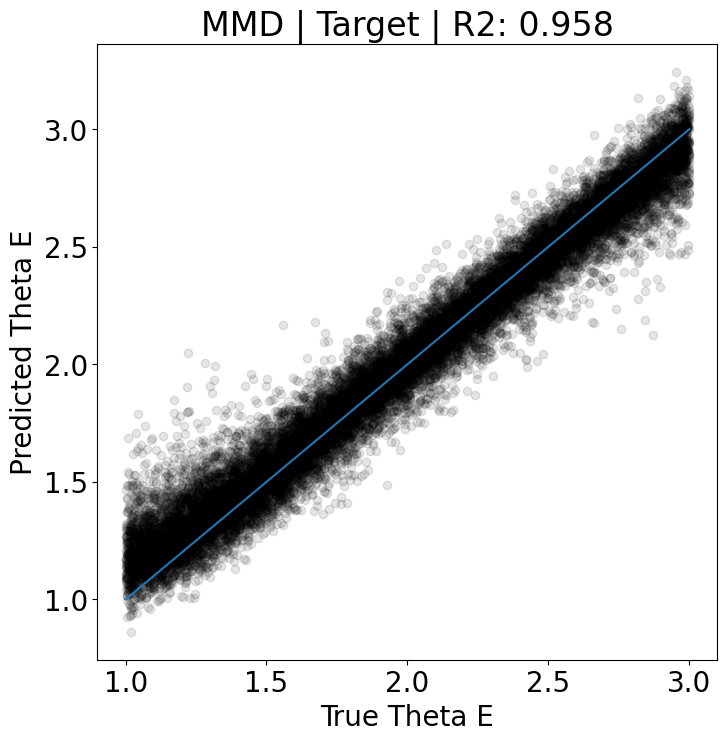

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.958')

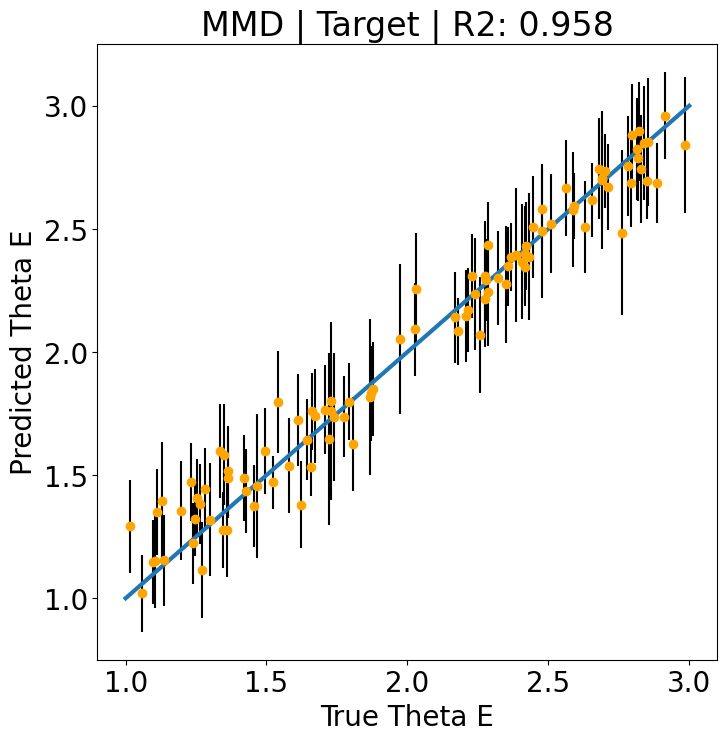

In [34]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.273')

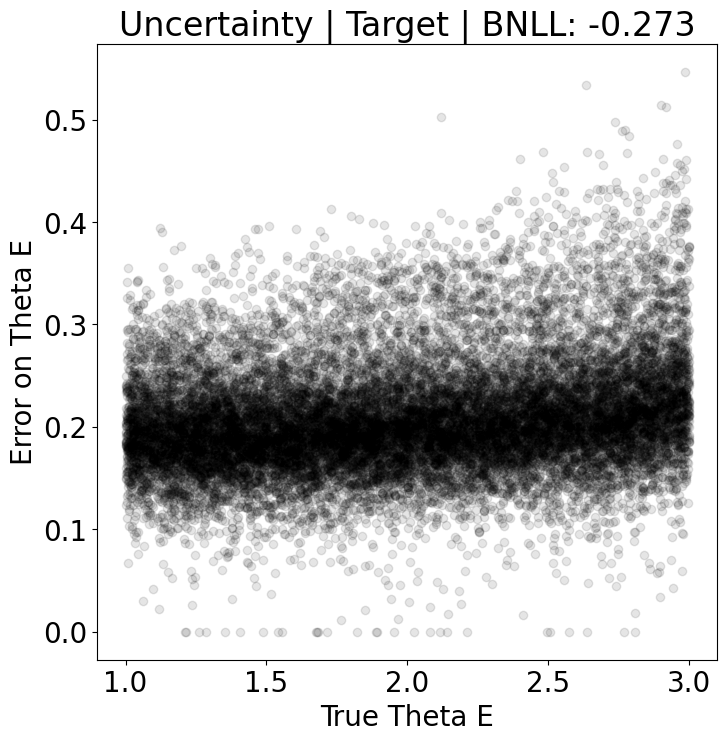

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [41]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

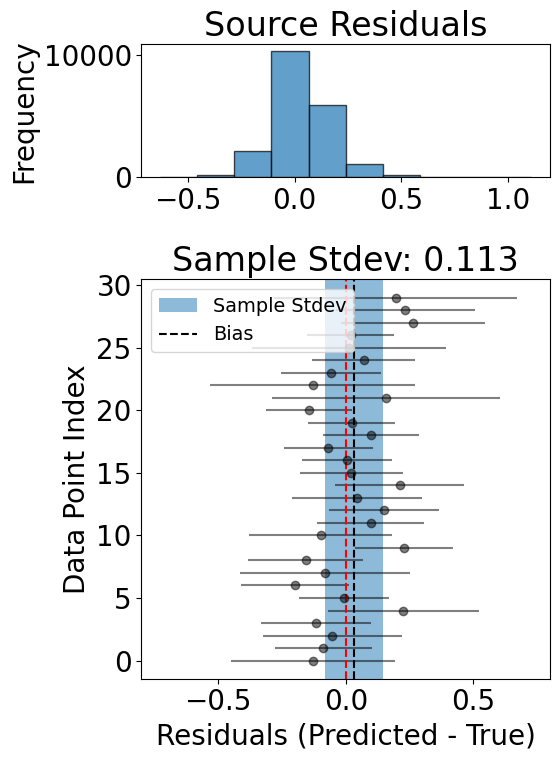

In [42]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

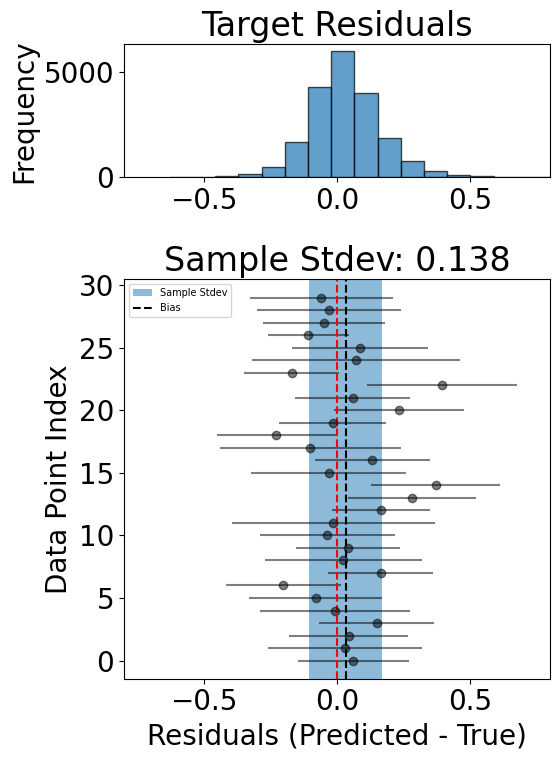

In [43]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()